In [1]:
#load CIFAR dataset
# pytorch, torch vision training and test example
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Lambda, Compose
from torch.utils.data.sampler import SubsetRandomSampler



training_data=datasets.CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )


0.0%

1.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

4.3%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

6.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

9.2%IOPub mes

97.2%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


Extracting data\cifar-10-python.tar.gz to data


In [38]:
def load_data(batch_size):
    indices=list(range(len(training_data)))
    split=int(0.7*len(training_data))
    train_sample=SubsetRandomSampler(indices[:split])
    val_sample=SubsetRandomSampler(indices[split:])
    train_loader=DataLoader(training_data,sampler=train_sample,batch_size=batch_size)
    val_loader=DataLoader(training_data,sampler=val_sample,batch_size=batch_size)
    print(len(train_loader),len(val_loader))

torch.Size([3, 32, 32]) tensor(9)


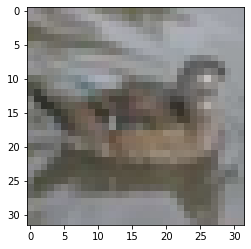

In [27]:
import numpy as np
data,y=next(iter(train_loader))
print(data[0,:,:,:].shape,y[0])
img=np.array(data[31,:,:,:])
img=np.moveaxis(img,0,-1)
plt.imshow(img)

In [50]:
import torch
from torch import nn as nn
from torch.nn import functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.features =16
        # encoder
        self.enc1 = nn.Linear(in_features=3072, out_features=128)
        self.enc2 = nn.Linear(in_features=128, out_features=self.features * 2)

        # decoder
        self.dec1 = nn.Linear(in_features=self.features, out_features=128)
        self.dec2 = nn.Linear(in_features=128, out_features=3072)
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5 * log_var)  # standard deviation
        eps = torch.randn_like(std)  # generate sample of the same size
        sample = mu + (eps * std)  # sampling as if coming from the input space
        return sample
            

    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = self.enc2(x).view(-1, 2, self.features)
        # get `mu` and `log_var`
        mu = x[:, 0, :]  # the first feature values as mean
        log_var = x[:, 1, :]  # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)

        # decoding
        x = F.relu(self.dec1(z))
        reconstruction = torch.sigmoid(self.dec2(x))
        return reconstruction, mu, log_var
    
def train(model,training_data,epochs):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.BCELoss(reduction='sum')
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(device)

    running_loss = 0.0

    for epoch in range(epochs):  # loop over the dataset multiple times

        for i, (inputs,y) in enumerate(training_data):
            #inputs, _ = data
            inputs = inputs.view(inputs.size(0), -1)

            optimizer.zero_grad()
            reconstruction, mu, logvar = model(inputs)
            bce_loss = criterion(reconstruction, inputs)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 200 == 199:  # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0

    PATH = 'cifar_VAE_net.pth'
    torch.save(model.state_dict(), PATH)

    print('Finished Training')
    
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [51]:
epochs=50
load_data(32)
model=VAE()
train(model,train_loader,epochs)

1094 469
cuda
[1,   200] loss: 130270.500
[1,   400] loss: 124389.403
[1,   600] loss: 123665.930
[1,   800] loss: 123330.245
[1,  1000] loss: 123440.595
[2,   200] loss: 181060.165
[2,   400] loss: 123408.706
[2,   600] loss: 123227.519
[2,   800] loss: 123068.839
[2,  1000] loss: 123362.955
[3,   200] loss: 181078.078
[3,   400] loss: 123552.405
[3,   600] loss: 123102.495
[3,   800] loss: 123268.895
[3,  1000] loss: 123090.990
[4,   200] loss: 181032.609
[4,   400] loss: 123103.192
[4,   600] loss: 123116.444
[4,   800] loss: 123346.059
[4,  1000] loss: 123084.092
[5,   200] loss: 180962.504
[5,   400] loss: 123368.136
[5,   600] loss: 123215.176
[5,   800] loss: 123120.037
[5,  1000] loss: 122823.171
[6,   200] loss: 181062.556
[6,   400] loss: 123209.628
[6,   600] loss: 123049.211
[6,   800] loss: 122968.415
[6,  1000] loss: 123357.837
[7,   200] loss: 181314.281
[7,   400] loss: 123292.217
[7,   600] loss: 123245.185
[7,   800] loss: 122880.702
[7,  1000] loss: 122996.548
[8,   

In [57]:
val_input,val_y=next(iter(val_loader))
val_input2 = val_input.view(val_input.size(0), -1)
print(val_input.shape,val_input2.shape)
model.eval()
val_outputs=model(val_input2)

torch.Size([32, 3, 32, 32]) torch.Size([32, 3072])


In [90]:
print(val_outputs[0].shape,val_outputs[1].shape,val_outputs[2].shape,len(val_outputs))

torch.Size([32, 3072]) torch.Size([32, 16]) torch.Size([32, 16]) 3


In [83]:
val_out=torch.reshape(val_outputs[0],(32,3,32,32))
print(val_out.shape)

torch.Size([32, 3, 32, 32])


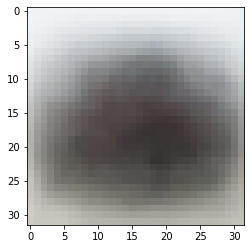

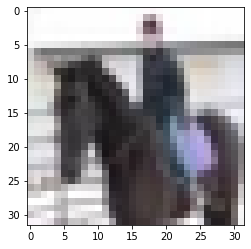

In [93]:
img2=val_out[27,:,:,:].detach().numpy()
img2=np.moveaxis(img2,0,-1)
plt.imshow(img2)
plt.show()

img3=val_input[27,:,:,:].detach().numpy()
img3=np.moveaxis(img3,0,-1)
plt.imshow(img3)
plt.show()